# Vector - Technical Analysis

# **Contents**

---
* [**1. Introduction**](#1.-Introduction)
* [**2. Data Overview**](#2.-Data-Overview)
* [**3. Importing Packages**](#3.-Importing-Packages)
* [**4. Defining Functions**](#4.-Defining-Functions)
* [**5. Importing Data**](#5.-Importing-Data)
* [**6. Part 1 - Determining Typical Daily Load Profiles**](#6.-Part-1---Determining-Typical-Daily-Load-Profiles)
 * [**6.1. Assumptions and Limitations - Part 1**](#6.1.-Assumptions-and-Limitations---Part-1)
 * [**6.2. Feature Exploration & Engineering**](#6.2.-Feature-Exploration-&-Engineering)
 * [**6.3. Modelling The Daily Residential Electricity Consumption Profile**](#6.3.-Modelling-The-Daily-Residential-Electricity-Consumption-Profile)
* [**7. Part 2 - Determine The Most Beneficial Customers For Insulation**](#7.-Part-2---Determine-The-Most-Beneficial-Customers-For-Insulation)
 * [**7.1. Assumptions And Limitations - Part 2**](#7.1.-Assumptions-And-Limitations---Part-2)
 * [**7.2. Alligning The Datasets**](#7.2.-Alligning-The-Datasets)
 * [**7.3. Interpolating Aggregating And Merging The Datasets**](#7.3.-Interpolating-Aggregating-And-Merging-The-Datasets)
 * [**7.4. Electricity Consumption Difference Calculation**](#7.4.-Electricity-Consumption-Difference-Calculation)
 * [**7.5. Modelled Dependence Of Consumption On Temperature**](#7.5.-Modelled-Dependence-Of-Consumption-On-Temperature)
 * [**7.6. Comparision Of SHAP Dependence And Winter-Summer Diffrence**](#7.6.-Comparision-Of-SHAP-Dependence-And-Winter-Summer-Diffrence)

## 1. Introduction
---
### Residential electricity load profiles

#### You have been provided an historical sample of residential smart meter load data for 50 residential customers and temperature data for Auckland for the full year 2015. Smart meters measure electricity consumption (kWh) in 30-min intervals. You have also received hourly temperature data for Auckland in 2015.

You are asked to please complete the following 2 parts of analysis:

1. The customer connections team is helping a property developer to size infrastructure for a new residential development and wants to know what the load as a group may look like and what variations may be expected. They ask you to determine typical daily load profile(s) (24 hours from midnight to midnight) for winter and summer at aggregate level. Please comment in the script on how you chose to define typical and why.

2. The customer connections team also considers asking the developer to put additional insulation into certain houses but given the current budget constraints due to COVID-19, it knows that the developer can only do this for the houses with the highest gain. Please determine the 10% of customers who will benefit the most.

## 2. Data Overview
---

### Smart Meter Load Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_MeterSample50.csv
#####  
##### Information Overview:
 - **TradingPeriod**:  30 minute time intervals that reset each day (1-48)
 - **MeterPollDateKey**:  A date key (YYYYMMDD)
 - **ICPKey**:  Installation control point number for residential smart meters (contains unique 50 entries)
 - **ElecCons_kWh**:  Data on kilowatt hour electricity consumption within the trading period (e.g. the **ElecCons_kWh** corresponding to the **TradingPeriod** of 1 would be the average rate of consumption between 12am and 12:30am in kWh. so a **ElecCons_kWh** of 0.2 would amount to using 0.1 kW of electricity)

### Temperature Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_Weather2015.csv
#####  
##### Information Overview:
 - **HourStart**: Time of day in 1 hour time intervals (0-23)
 - **DateKey** : A date key (YYYYMMDD)
 - **Temp_DegCelsius**: The temperature. For this analysis, what i consider to be, the simplist interpretation will be used which is that the feature **Temp_DegCelsius** is the temperature at the start of the hour (e.g. the value corresponding to an **HourStart** of 0 is the temperture at 12am). The way that the **HourStart** feature is worded leaves me wondering if this is somthing more along the lines of the average temperature over the hour that started at 12am or even the temperature at the midpoint of the hour (e.g. the temperature at 12:30am) clarifying this would be recomended as it effects how the meter data can be joined on.

## 3. Importing Packages
---

In [4]:
# File system management
import os
# Setting the directory to the parent directory
os.chdir('..')

# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# Interpolate and random for data extension
from scipy import interpolate
import random

# Datetime for handling datetime variables
import datetime as dt

# Importing algorithms
# from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from xgboost import XGBRegressor

# shap for model interpretability
import shap

# Sklearn label encoder
from sklearn.preprocessing import LabelEncoder

# Sklearn data splitting
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Sklearn importing measurement metric for temp correlation of consumption
from sklearn.metrics import mean_squared_error

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 4. Defining Functions
---

A season feature funtion

In [5]:
def season(df):
    # Basic function to define a summer, winter or other feature for the southern hemisphere in 2015.
    if ((df['Date'] <= dt.date(2015, 3, 21)) | (df['Date'] >= dt.date(2015, 12, 22))):
        val = 'Summer'
    elif ((df['Date'] >= dt.date(2015, 6, 22)) & (df['Date'] <= dt.date(2015, 9, 23))):
        val = 'Winter'
    else:
        val = 'Other'
    return val

A model fitting function

In [6]:
# A cross validation model fitting function. In this case there is probably no need for cross validation as we are simply looking 
# to understand the profile but I had thif function lying around from previous projects.
def model_fit(mdl, mdl_nme='', df=None, tgt_var=None, n_fld=5, output=True):   
    # basically a verbosity condition
    if output:
        print(f"{mdl_nme} fit")
              
    # K fold validation
    fld = KFold(n_splits=n_fld, shuffle=True, random_state=42)
    
    # List of feature columns
    fts = [f for f in df.columns if f not in [tgt_var]]
    
    # Initializing Variables
    prd = np.zeros(df[fts].shape[0])
    ful_prd = np.zeros(df[fts].shape[0])
    RMSE = 0
    MSE = 0
    RMSE_tot = 0
    MSE_tot = 0
    
    for n_fold, (trn_idx, vld_idx) in enumerate(fld.split(df[fts], df[tgt_var])):
        trn_X, trn_y = df[fts].iloc[trn_idx], df[tgt_var].iloc[trn_idx]
        vld_X, vld_y = df[fts].iloc[vld_idx], df[tgt_var].iloc[vld_idx]
        # Fit the model
        mdl.fit(trn_X, trn_y)
        
        prd[vld_idx] = mdl.predict(vld_X)
            
        # Appling the fit to the prediction set
        ful_prd += mdl.predict(df[fts])/fld.n_splits

        # Outputting the AUC
        MSE = mean_squared_error(vld_y, mdl.predict(vld_X))
        MSE_tot += MSE/fld.n_splits
        RMSE = np.sqrt(MSE)
        
        # Outputting statistics
        if output:
            print('Fold %2d RMSE : %.6f' % (n_fold + 1, RMSE))
    
    RMSE_tot = np.sqrt(MSE_tot)
    if output:
        print('RMSE over folds: %.6f' % RMSE_tot)
    # Note that at this stage this only returns the model from the final fold
    return RMSE_tot, ful_prd, mdl

Custom line plot function

In [7]:
def line_plot(data, group, x='', y='', title=''):   
    plot = sns.FacetGrid(data, hue=group, height=4, aspect=4)
    plot.map(plt.plot, x, y)
    plot.fig.suptitle(title)
    plot.add_legend()

Profile plottig function

In [8]:
def profile_plot(df, fig_name=''):
    
    # Plotting the measured consumption aggregated over all 50 sampled ICPKeys
    plt.plot(df['TradingPeriod'], df['ElecCons_kWh'], 'o', color='seagreen', alpha=0.08);
    
    # Aggregating the consumption to a average daily profile
    df = pd.DataFrame(df.groupby(['TradingPeriod'])[['5th_ElecCons_kWh', '25th_ElecCons_kWh', 'Expected_ElecCons_kWh', '75th_ElecCons_kWh', '95th_ElecCons_kWh']]
                        .mean()
                        .reset_index(level=['TradingPeriod']))
    
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['5th_ElecCons_kWh'], ':', color='mediumblue', label = "5th percential", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['25th_ElecCons_kWh'], '--', color='mediumblue', label = "25th percential", linewidth=2)
    # Plotting the best fit
    plt.plot(df['TradingPeriod'], df['Expected_ElecCons_kWh'], '-', color='black', label = "Best Fit", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['75th_ElecCons_kWh'], '--', color='mediumblue', label = "75th percential", linewidth=2)
    # Plotting the 95th percentile
    plt.plot(df['TradingPeriod'], df['95th_ElecCons_kWh'], ':', color='mediumblue', label = "95th percentile", linewidth=2)

    # Setting the title axies and legend
    plt.xlabel('Trading Period (30 min intervals)', size=14)
    plt.ylabel('Electricity Consumption (kWh)', size=14)
    plt.title(f"Daily Residential Electricity Consumption Profile - {fig_name}", size=20)
    plt.legend()

    # Display and save the figure.
    fig = plt.gcf()
    fig.set_size_inches(16, 6, forward=True)
    fig.savefig(f"figures/Electricity-Consumption-Profile-{fig_name}.png", dpi=100)

Calculate the average absolute shap value

In [9]:
def avg_abs_shap_value(model, df, feature):
    # For info on SHAP values: https://github.com/slundberg/shap
    
    # List of feature columns
    features = [f for f in df.columns if f not in ['ElecCons_kWh']]
    X = df[features]
    y = df['ElecCons_kWh']
    
    # Fitting a random forrest regressor
    model.fit(X, y)
    
    # Calculating the average absolute shap value
    shap_values = shap.TreeExplainer(model, data=X, feature_perturbation="tree_path_dependent").shap_values(X)
    shap_df = pd.DataFrame(shap_values)
    shap_df.columns = X.columns
    avg_abs_impact = shap_df[feature].abs().mean()

    return avg_abs_impact    

## 5. Importing Data
---

### Importing The Meter Sample Dataset (Data_MeterSample50.csv)

In [10]:
# Importing the meter dataset as a pandas dataframe
meter_df = pd.read_csv('data/Data_MeterSample50.csv')

In [11]:
meter_df.head()

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
0,5972076,20150101,1,0.16
1,5972076,20150101,2,0.17
2,5972076,20150101,3,0.13
3,5972076,20150101,4,0.15
4,5972076,20150101,5,0.16


In [12]:
# Note that there is a maximum trading period of 50 which I'm assuming is because of daylight savings causing an hour to appear twice (and conversely there is probably a day that only went up to 46.
# Ideally we should create a datetime variable and adjust to UTC to account for this shift
meter_df.describe(include='all')

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
count,8.759500e+05,8.759500e+05,875950.000000,875950.000000
mean,6.155496e+06,2.015067e+07,24.501564,0.500849
std,2.016792e+05,3.450066e+02,13.853280,0.550925
min,5.972076e+06,2.015010e+07,1.000000,0.000000
25%,6.015713e+06,2.015040e+07,13.000000,0.119000
50%,6.033299e+06,2.015070e+07,25.000000,0.294900
75%,6.402389e+06,2.015100e+07,37.000000,0.685900
max,6.578393e+06,2.015123e+07,50.000000,5.710000


### Importing The Hourly Temperature Dataset

In [13]:
# Importing and concatenating the monthly readings
temp_df = pd.read_csv('data/Data_Weather2015.csv')

In [14]:
temp_df.head()

,DateKey,HourStart,Temp_DegCelsius
0,20150101,0,19.00
1,20150101,1,18.75
2,20150101,2,17.25
3,20150101,3,16.50
4,20150101,4,16.50


In [15]:
# Note: No additional hours from daylight savings but there will probably be a day with a repeated hour and a day with a missing hour.
temp_df.describe(include='all')

,DateKey,HourStart,Temp_DegCelsius
count,8.760000e+03,8760.000000,8760.000000
mean,2.015067e+07,11.500000,15.206117
std,3.450216e+02,6.922582,4.089467
min,2.015010e+07,0.000000,3.500000
25%,2.015040e+07,5.750000,12.250000
50%,2.015070e+07,11.500000,15.000000
75%,2.015100e+07,17.250000,18.000000
max,2.015123e+07,23.000000,26.500000


## 6. Part 1 - Determining Typical Daily Load Profiles
---

##### In order to determine a "typical" daily load profile a gradient boosted regressor was used to find the best fit for the summer and winter profiles (further optimisation would be beneficial).
##### The expected variations are captured with quantile gradient boosted regressions at the 5th, 25th, 75th and 95th percentiles.

Some exploration was done on removing outliers such as weekends or public holidays but it was not included in the final analysis as it is presumed to inform the variations captured in the quantile envelopes.

### 6.1. Assumptions and Limitations - Part 1
---
      
1. Summer ends on Saturday, 21 March, Winter starts on Sunday, 22 June and ends on Wednesday, 23 September and Summer starts again on Monday, 22 December (source: google). This assumes that the property developer is interested in the more extreme temperature profiles.

2. As we are looking at the daily load profiles factors such as temperature weather or other factors are not used.

3. The property developer is expected to build in auckland.

4. The property developer is building houses that are equatable to the historical data used (e.g. they're not building appartments while were analysing houses).

5. The socio-demographic profiles of the historic data households is expected to match those who will move into the property development.

6. No outliers were removed as they are expected to inform the variations that the property developer is interested in and there is no reason to belive any data is erorneuos.

7. The additional and missing trading periods cause by daylight savings can be ignored as they do not lie in the summer or winter intervals.

8. No effort ws made to optimise the model.

### 6.2. Feature Exploration & Engineering
---

#### Creating a Season Feature

In [16]:
# Converting the date to a datetime feature
meter_df['Date'] = pd.to_datetime(meter_df['MeterPollDateKey'], format='%Y%m%d')

In [17]:
# Creating a winter, summer and other feature
meter_df['Season'] = meter_df.apply(season, axis=1)

In [18]:
# Creating a plotable dataframe
kWh_by_season_df = pd.DataFrame(meter_df.groupby(['Season','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_season_df.reset_index(level=['Season','TradingPeriod'], inplace=True)

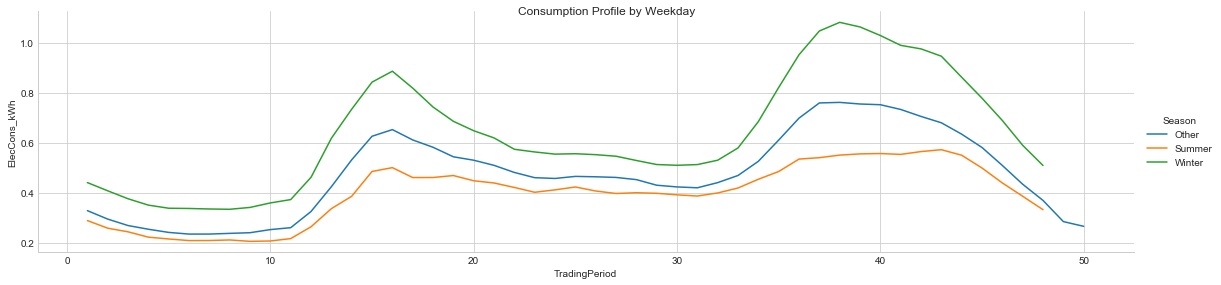

In [19]:
# Plotting the distributions of price against weekdays. 
# This shows clearly different profiles with winter being the most intense consumption suggesting that electric heating or more time spent in doors might be the biggest factors.
line_plot(data=kWh_by_season_df, group='Season', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [20]:
# Creating a dictionary for the weekend flag
season_dict = {"Summer": 0, "Winter": 1, "Other": 2}
meter_df['Season_Int'] = meter_df['Season'].map(season_dict)

#### Creating a Weekday and Weekend Feature

In [21]:
# Creating a weekday feature
meter_df['Weekday_Int'] = (meter_df['Date'].dt
                                           .weekday)
# Creating a maping dictionary
day_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",4: "Friday", 5: "Saturday", 6: "Sunday"}
meter_df['Weekday'] = meter_df['Weekday_Int'].map(day_dict) 

In [22]:
# Creating a plotable dataframe
kWh_by_weekday_df = pd.DataFrame(meter_df.groupby(['Weekday','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_weekday_df.reset_index(level=['Weekday','TradingPeriod'], inplace=True)

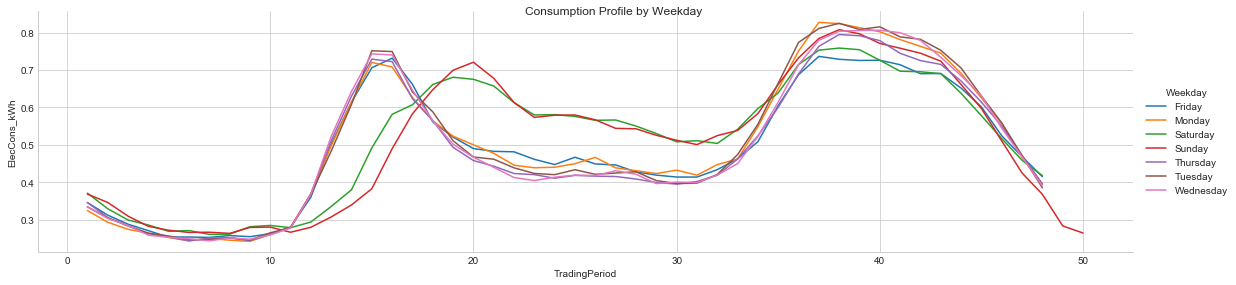

In [23]:
# Plotting the distributions of consumption against weekday
line_plot(data=kWh_by_weekday_df, group='Weekday', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [24]:
# Creating a dictionary for the weekend flag
weekend_dict = {"Monday": 0, "Tuesday": 0,"Wednesday": 0,"Thursday": 0,"Friday": 0,"Saturday": 1,"Sunday": 1}
meter_df['Weekend'] = meter_df['Weekday'].map(weekend_dict)

I used this feature for a quick explortion of impacts of day of the week and produced a couple profiles with the weekends seperated out and it's a significant contributer. 
Perhaps a weekday could be used as the typical profile?
Due to time constraints and to maintain simplicity I didnt explore it further.

#### Creating a Public Holiday Flag

Although I didn't get around to it I image public holidays will also display significantly different profiles (perhaps similar to weekends?).

I also expect the profiles throuhout winter ans summer will be different accouse the mounths but again I didn't explore it.

#### Creating a Month Feature

In [25]:
# Creating a month feature
meter_df['Month_Int'] = (meter_df['Date'].dt
                                         .month)
# Creating a dictionary
mo_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
meter_df['Month'] = meter_df['Month_Int'].map(mo_dict)

In [26]:
# Creating a plotable dataframe
kWh_by_month_df = pd.DataFrame(meter_df.groupby(['Month','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_month_df.reset_index(level=['Month','TradingPeriod'], inplace=True)

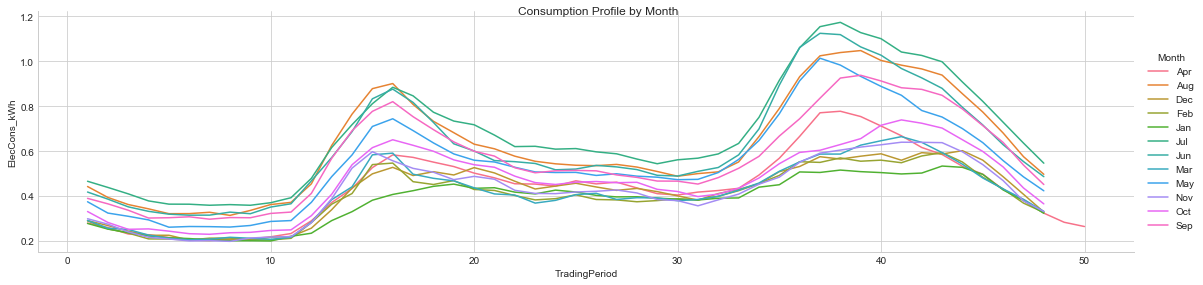

In [27]:
# Plotting the distributions of consumption against month
line_plot(data=kWh_by_month_df, group='Month', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Month')

This shows significant seperation between July and Sept even though they are both winter months. Perhaps a central month of the season cold be chosen as the typical profile? The three lowest usage moths are Jan followed by Dec and Feb which is squarly in summer.

### 6.3. Modelling The Daily Residential Electricity Consumption Profile
---

In order to maintain some simplicity I have defined the 'typical' profile as the best fit profile over the entire winter and summer seasons.

I did explore the possibility of creating a subset such as separating out weekdays from weekends and public holidays, using just a month from the center of the season, or even a day with a typical temperature profile. In the end due partly to maintaining simplicity but mostly due to the property developer wanting to understand variations I choose not to select a subset for the typical profile.

In [28]:
# Aggregating the consumtion to a total accross all 50 sampled ICPKeys
model_df = pd.DataFrame(meter_df.groupby(['MeterPollDateKey', 'TradingPeriod', 'Season_Int'])[['ElecCons_kWh']]
                                .sum()
                                .reset_index(level=['MeterPollDateKey', 'TradingPeriod', 'Season_Int'])
                                .sort_values(by=['TradingPeriod']))

In [29]:
# Selecting a simple dataset for the profile model
model_df = model_df[['TradingPeriod', 'ElecCons_kWh', 'Season_Int']]

The methodology applied below is based on Will Koehrsens Towards Data Science post: https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed.
Another article using the renowned XGBoost algorithm with a similar methodology is described by Benoit Descamps here: https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b and should be explored for profile mapping in the future (XGB tends to outperform GBT).

In [33]:
# Calculate the lower 5th percential
gbr_5 = GradientBoostingRegressor(loss="quantile", alpha=0.05, random_state=42)
loss, kWh_5th, _ = model_fit(gbr_5, 'Lower 5 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['5th_ElecCons_kWh'] = kWh_5th

# Calculate the lower 12.5th percential
gbr_25 = GradientBoostingRegressor(loss="quantile", alpha=0.25, random_state=42)
loss, kWh_25th, _ = model_fit(gbr_25, 'Lower 25 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['25th_ElecCons_kWh'] = kWh_25th

# Calculate the upper 75th percential
gbr_75 = GradientBoostingRegressor(loss="quantile", alpha=0.75, random_state=42)
loss, kWh_75th, _ = model_fit(gbr_75, 'Upper 75 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['75th_ElecCons_kWh'] = kWh_75th

# Calculate the upper 95th percential
gbr_95 = GradientBoostingRegressor(loss="quantile", alpha=0.95, random_state=42)
loss, kWh_95th, _ = model_fit(gbr_95, 'Upper 95 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['95th_ElecCons_kWh'] = kWh_95th

# Calculate the best fit
gbr = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)
loss, expected_kWh, _ = model_fit(gbr, 'Gradient Boosting Regressor', model_df, 'ElecCons_kWh')
model_df['Expected_ElecCons_kWh'] = expected_kWh

Gradient Boosting Regressor fit
Fold  1 RMSE : 5.297884
Fold  2 RMSE : 5.554802
Fold  3 RMSE : 5.603935
Fold  4 RMSE : 5.622291
Fold  5 RMSE : 5.523638
RMSE over folds: 5.521743


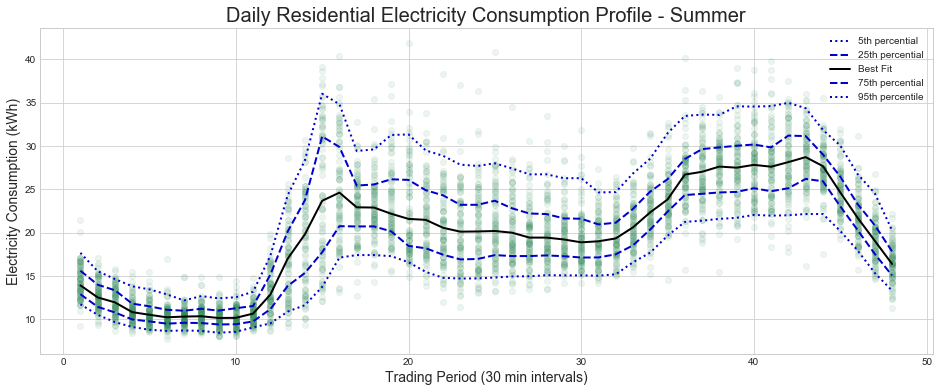

In [34]:
summer_weekday_df = model_df.where(model_df.Season_Int == 0)
profile_plot(summer_weekday_df, fig_name='Summer')

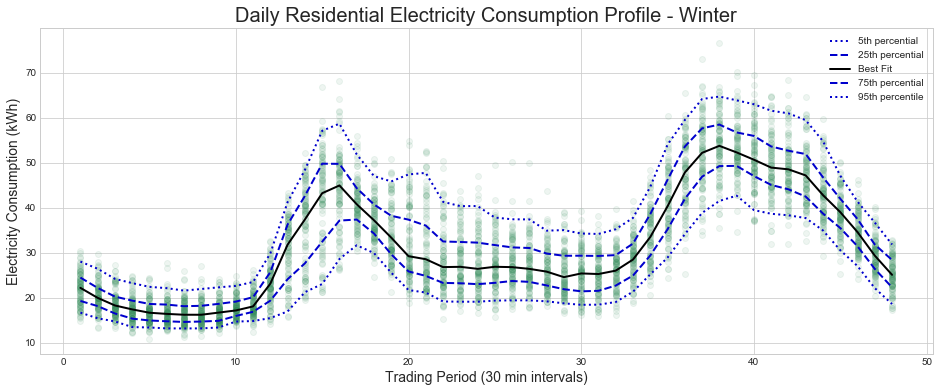

In [35]:
winter_weekday_df = model_df.where(model_df.Season_Int == 1)
profile_plot(winter_weekday_df, fig_name='Winter')

## 7. Part 2 - Determine The Most Beneficial Customers For Insulation
---

#### Who will benefit the most?

In order to find the "houses with the highest gain" or "who will benifit the most" a definition of gain and benifit in this context will need to be established. 
While it may be debatable I will assert that the reduction of overall electricity consumption is not as important as the number of people and specifically how many vulnerable people (young and elderly, etc.) would be positivly impacted by having insulation. There is also a strong posibility that the less welthy housholds (maybe the ones with more vulnerable people or dependents) have tried to save money on there electricity bills and historical meter data will not show the benifits that these households would get.

A thorough and holistic approach would be to collect additional data such as, internal temperature and socio-demographic information (number of people, age, income, expenses, etc) should be obtained. I expect that socio-demographic data would be obtainable from sources like Statistics NZ; including data on households whose power can't be turned off due to medical or other reasons. The household's temperature dependent electricity consumption could then be modelled (with non-linear feature dependence) and decomposed to find the electricity consumption required to maintain a comfortable temperature while removing the impacts of socio-demographic factors like income and expenses. The benefits could then be weighted to account for the number of people or more specifically the number of vulnerable people.

##### Given that the data provided (or readily obtainable) does not contain this information I've reframed the problem to identifying which households have the most temperature dependent electricity consumption (as this is what insulation will theoretically reduce).

To address this reframed problem with the data available the following method was appliedc:

To align the time scale and metric types in the meter and temperature datasets a pchip interpolation and mean aggregation was applied to the temperature data to find the average temperature for each trading period before merging them into a single dataframe.
From there two methods were applied to answer this question:
- Firstly, a very simple calculation of the difference in consumption between summer and winter for each household. In addition to the assumptions listed in 7.1. (below) this method assumes:
    - No electricity is used for cooling; and
    - The difference in consumption from winter to summer is entirely related to temperature (no effect of shorter daylight hours or more rain in winter etc).
- Secondly, a model of the electricity consumption was constructed for each household, using a random forest regressor, before applying SHAP analysis (read about SHAP here: https://github.com/slundberg/shap) to decompose the impact that temperature had on the consumption. This addresses the limitations listed above by:
    - taking the the average absolute impact on consumption we can account for cooling effects; and
    - by adding features like month and time of day we can (to a certain extent) account for shorter daylight hours or more rain in winter; although, a more complete dataset and accurate model would be beneficial.
 The first method (difference calculation) indicates that the 10% of households that have the most temperature dependent electricity consumption can be identified by the ICP Keys 6562044, 6016524, 6113779, 6015713,  and 6406908.
The second method (modelled SHAP dependence) indicates that the 10% of households that have the most temperature dependent electricity consumption can be identified by the ICP Keys 6023045, 6016524, 6113779, 6015713 and  6406908.
A full comparison can be seen in the figure at the end of the notebook.

While, it is reassuring to see that both methods returned 4 out of 5 of the same households due to the shortcomings in the first method I would suggest that the property developer insulate the households with the closest similarities to the ones with the ICP Keys returned by the SHAP dependence (6023045, 6016524, 6113779, 6015713 and 6406908).

### 7.1. Assumptions And Limitations - Part 2
 
1. Summer ends on Saturday, 21 March and winter starts on Sunday, 22 June and ends on Wednesday, 23 September and summer starts again on Monday, 22 December (source: google). This assumes that the property developer is interested in the more extreme temperature profiles.

2. The some range of features and not having demographic data or meteorological effects is a significant limitation on the modeled accuracy.

3. Insulation has a proportional impact on temperature dependent electricity consumption for both heating and cooling.

4. Impacts like reduced sunlight hours or increased rain is captured in the temporal features (month).

5. No effort was made to optimise the model.

### 7.2. Alligning The Datasets
---

#### In order to merge the datasets the temporal features (DataWeather2015:HourStart and Data_MeterSample50:TradingPeriod) need to be alligned.

##### Assuming that temperature reading has been taken on the hour and the meter reading is the rate of consumption derived from the total usage over that half hour period. In order to align the datasets there are a few options:
1. Aggregate both data sets up to a daily level taking the total usage and maybe a min and max or average temperature.
- Note:
    - This is a naive method and wouldn't account for days with different temperature profiles.
2. Join the meter dataset to the temperature dataset at the nearest hour e.g. the meter reading with a **TradingPeriod** of 4 (1:30am-2:00am) and 5 (2:00am-2:30am) would be joined onto the nearest temperature reading which has an **HourStart** of 2 (2:00am). 
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - The temperature readings would not accurately correspond to the meter readings (there would be a 15m shift from the center of the trading periods).
3. Aggregate (by taking the mean) the meter readings to the nearest hour e.g. if there was a **ElecCons_kWh** of 0.3 at a **TradingPeriod** of 4 (1:30am-2:00am) and a **ElecCons_kWh** of 0.4 at a **TradingPeriod** of 5 (2:00am-2:30am) they would be aggregated into a **ElecCons_kWh** of 0.35 over a trading period of 1 hour centered around 2:00am.
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - Granularity of the meter readings would be reduced.
4. Interpolating the temperature measurements to find the temperature profile and aggregating to the average across the trading period.
- Note: 
    - Granularity is maintained.
    - Temperature readings would only be interpolations (not strictly accurate but better then the other two options).
    - A bit more work.
5. Sourcing more granular weather data. This would likely also lead to more meteorological features such as rain, wind etc. which I expected to have a significant effect on the heating of the house. I had a bit of a look into finding this data but detailed historical weather data seems to only be readily available behind paywalls...

##### Option 4 was choosen as interpolating and aggregating in python is only a few lines of code and should produce the most accurate and robust method (and it's more intresting).

### 7.3. Interpolating Aggregating And Merging The Datasets
---

In [37]:
# Combining the HourStart and DateKey Features into a DateTime feature
temp_df['DateTime'] = temp_df['DateKey'].astype(str)+temp_df['HourStart'].astype(str)
temp_df['DateTime'] = pd.to_datetime(temp_df['DateTime'], format='%Y%m%d%H')

In [38]:
# Creating a 1 min interval datetime feature
date_data = {'DateTime': pd.date_range(start='1/1/2015', end='1/1/2016', freq='1min')}
df = pd.DataFrame(date_data)
df.drop(df.tail(1).index, inplace=True)
temp_df = pd.merge(df, temp_df, how='left', on=['DateTime'])

In [39]:
# Running a quick piecewise cubic hermite interpolating polynomial (pchip) interpolation
temp_df['Temp_DegCelsius_Itpl'] = temp_df['Temp_DegCelsius'].interpolate(method='pchip')

In [40]:
# Aggregating up to the average temperature over the trading period
temp_df['DateTime'] = temp_df['DateTime'].dt.floor("30min")
temp_df = pd.DataFrame(temp_df.groupby(['DateTime'])['Temp_DegCelsius_Itpl'].mean())
temp_df.reset_index(level=['DateTime'], inplace=True)

In [41]:
temp_df = temp_df[['DateTime', 'Temp_DegCelsius_Itpl']]
temp_df.columns = ['TradingPeriodStart','Temp_DegCelsius_Avg']

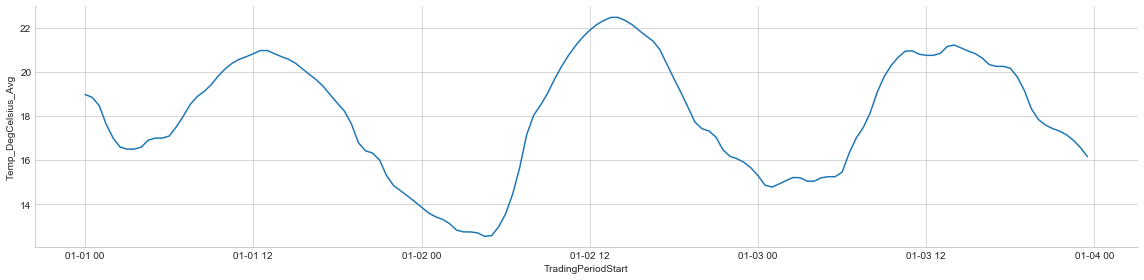

In [42]:
# Quick look at the interpolated and aggregated temperature over 3 days
plot = sns.FacetGrid(temp_df.head(144), height=4, aspect=4)
plot.map(plt.plot, 'TradingPeriodStart', 'Temp_DegCelsius_Avg')

In [43]:
# Dropping the values were there are more then 48 trading periods from daylight savings.
meter_df = meter_df.where(meter_df['TradingPeriod'] <= 48).dropna()
# Combining the MeterPollDateKey and TradingPeriod features into a TradingPeriodStart datetime feature.
meter_df['TradingPeriodStart'] = (meter_df['MeterPollDateKey'].astype(int).astype(str) 
                        + ((meter_df['TradingPeriod']-1)/2).astype(int).astype(str).str.zfill(2) 
                        + (((meter_df['TradingPeriod']-1)%2)*30).astype(int).astype(str).str.zfill(2))
meter_df['TradingPeriodStart'] = pd.to_datetime(meter_df['TradingPeriodStart'], format='%Y%m%d%H%M')

In [44]:
# Merging the meter dataframe and the interpolated and aggregated temperature dataframes.
df = pd.merge(meter_df, temp_df, how='inner', on=['TradingPeriodStart'])

### 7.4. Electricity Consumption Difference Calculation
---

##### Calculating the difference in consumption from summer to winter.
The 'Consumption Profile by Month' figure in section 6.2 indicates that the difference in consumption between summer and winter is greater than that between any other months so cooling costs might not be a significant factor for all households.

In [45]:
# Aggregating the data.
temp_avg_df = pd.DataFrame(df.groupby(['Season', 'ICPKey'])['Temp_DegCelsius_Avg'].mean())
temp_avg_df.reset_index(level=['Season', 'ICPKey'], inplace=True)
elec_cons_df = pd.DataFrame(df.groupby(['Season', 'ICPKey'])['ElecCons_kWh'].mean())
elec_cons_df.reset_index(level=['Season', 'ICPKey'], inplace=True)

In [46]:
# Merging the aggregated dataframes.
difference_df = pd.merge(temp_avg_df, elec_cons_df, how='inner', on=['Season', 'ICPKey'])

In [47]:
# Calculating the difference in consumption betwen summer and winter.
difference_df = difference_df.pivot(index='ICPKey', columns='Season')
difference_df['ElecConsDiff_kWh'] = difference_df['ElecCons_kWh']['Winter'] - difference_df['ElecCons_kWh']['Summer']

In [48]:
# Displaying the top 5 (or 10% of residential meters) with the gratest difference in consumption between summer and winter.
difference_df.sort_values(by=['ElecConsDiff_kWh'], ascending=False).head(5)

Temp_DegCelsius_Avg                       ElecCons_kWh            \
Season                  Other     Summer     Winter        Other    Summer   
ICPKey                                                                       
6016524.0           15.091140  19.608848  11.214655     0.663059  0.411655   
6406908.0           15.090812  19.608848  11.214655     0.789466  0.399118   
6015713.0           15.089912  19.608848  11.214655     0.490126  0.340340   
6113779.0           15.091140  19.608848  11.214655     0.697110  0.490318   
6562044.0           15.090812  19.608848  11.214655     0.500679  0.432786   

                    ElecConsDiff_kWh  
Season       Winter                   
ICPKey                                
6016524.0  1.115883         0.704227  
6406908.0  1.060550         0.661432  
6015713.0  0.918910         0.578570  
6113779.0  1.020526         0.530208  
6562044.0  0.959313         0.526527

The above indicates these housholds have the most electricity consumption due to cooling and therefore the most potential to reduce consumption with additional insulation.

This relies upon the assumptions that:
- No electricity is used for cooling; and
- The differnece in consumption from winter to summer is entirly related to temperature.

However if we take a look at the other end of the sample we see:

In [49]:
difference_df.sort_values(by=['ElecConsDiff_kWh'], ascending=False).tail(5)

Temp_DegCelsius_Avg                       ElecCons_kWh            \
Season                  Other     Summer     Winter        Other    Summer   
ICPKey                                                                       
6416606.0           15.091140  19.608848  11.214655     0.227715  0.190666   
6069096.0           15.089912  19.608848  11.214655     0.155813  0.152813   
6069807.0           15.091140  19.608848  11.214655     0.081722  0.085692   
6416107.0           15.091140  19.608848  11.214655     0.660761  0.709638   
6033299.0           15.090812  19.608848  11.214655     0.255369  0.356432   

                    ElecConsDiff_kWh  
Season       Winter                   
ICPKey                                
6416606.0  0.223824         0.033158  
6069096.0  0.154891         0.002078  
6069807.0  0.075390        -0.010302  
6416107.0  0.627526        -0.082112  
6033299.0  0.135562        -0.220870

##### Households with the lowest difference in consumption from summer to winter we see -ve values. This suggest that there are some households that only use electricity for cooling and little to no heating along with the fact that autumn and spring were ignored.
#### Indicating that this is perhaps an overly naive solution!

### 7.5. Modelled Dependence Of Consumption On Temperature
---

For a less naive solution I'm going to model the electricity consumption for each ICP key using a random forest (a simple yet powerful and robust algorithm). The SHAP (SHapley Additive exPlanations) values can then be used to identify the average impact on electricity consumption attributed to the outside temperature.

The shap git repo can be found here: https://github.com/slundberg/shap.
A full description of how shap values can be used to interpret the impact of variables on a model was written by Dr. Dataman and can be found here: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d.

In [50]:
# Creating a modelling dataframe (it's a very limited selection of features but for this eval it will have to do).
model_df = df[['Temp_DegCelsius_Avg', 'TradingPeriod', 'ElecCons_kWh', 'Season_Int', 'Weekday_Int', 'Weekend', 'Month_Int',]]
# Selecting a sub-sample to speed up SHAP value calculation.
model_df = model_df.sample(frac=0.1)

Quickly looking at the SHAP impacts on a single household.

Random Forest Regressor fit
Fold  1 RMSE : 0.060894
Fold  2 RMSE : 0.070112
Fold  3 RMSE : 0.055354
Fold  4 RMSE : 0.116211
Fold  5 RMSE : 0.089442
RMSE over folds: 0.081477


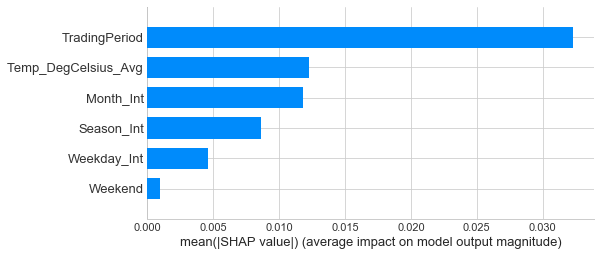

In [51]:
# Selecting a single ICPKey.
single_key_df = model_df.where(df.ICPKey == 6069807).dropna()

# Fitting a random forrest regressor.
RF = RandomForestRegressor(n_estimators=10, random_state=42)
RMSE, ExpElecCons_kWh, model = model_fit(RF, 'Random Forest Regressor', single_key_df, 'ElecCons_kWh')

# Calculating and plotting the shap values.
X = single_key_df[['Temp_DegCelsius_Avg', 'TradingPeriod', 'Season_Int', 'Weekday_Int', 'Weekend', 'Month_Int']]
shap_values = shap.TreeExplainer(model, data=X, feature_perturbation="tree_path_dependent").shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

##### The above indicates that, for at least some household's, the trading period and month of year are the most significant features but tempreture is still significant.

In [54]:
# Random Forest Regressor.
# Please note that for the purposes of this quick analysis no attempt has been made to optimise the hyperparameters or try different algorithms.
# Optimising the model is recommended as a better fit leads to more confidence in the SHAP values explanation.
RF = RandomForestRegressor(n_estimators=10, random_state=42)

In [55]:
# Creating a dataframe of each household's SHAP impact of the temperature on electricity consumption.
shap_df = pd.DataFrame(columns=['ICPKey', 'ElecConsImpct_kWh'])
for ICPKey in df['ICPKey'].unique():
    single_key_df = model_df.where(df.ICPKey == ICPKey).dropna()
    avg_abs_impact = avg_abs_shap_value(RF, single_key_df, 'Temp_DegCelsius_Avg')
    ICPKey_df = pd.DataFrame({'ICPKey': [int(ICPKey)], 'ElecConsImpct_kWh': [float(avg_abs_impact)]})
    shap_df = shap_df.append(ICPKey_df, ignore_index=True)
    
shap_df = shap_df.sort_values(by='ElecConsImpct_kWh')

### 7.6. Comparision Of SHAP Dependence And Winter-Summer Diffrence
---

In [56]:
# Merging and melting the results from the two methods
temp_dep_df = pd.merge(shap_df, difference_df['ElecConsDiff_kWh'], how='inner', on=['ICPKey'])
temp_dep_df = temp_dep_df.sort_values(by='ElecConsImpct_kWh', ascending=False)
temp_dep_df.reset_index(inplace=True)
temp_dep_df['Ordered ICP Key'] = temp_dep_df['index'].astype(str) + '. ' + temp_dep_df['ICPKey'].astype(str)
temp_dep_df.columns = ['index', 'ICPKey', 'SHAP impact Consumption Impact (kWh)', 'Summer to Winter Consumption Difference (kWh)', 'Ordered ICP Key']
temp_dep_df = pd.melt(temp_dep_df, id_vars=["Ordered ICP Key"], value_vars=['SHAP impact Consumption Impact (kWh)', 'Summer to Winter Consumption Difference (kWh)'])

<Figure size 1440x1440 with 0 Axes>

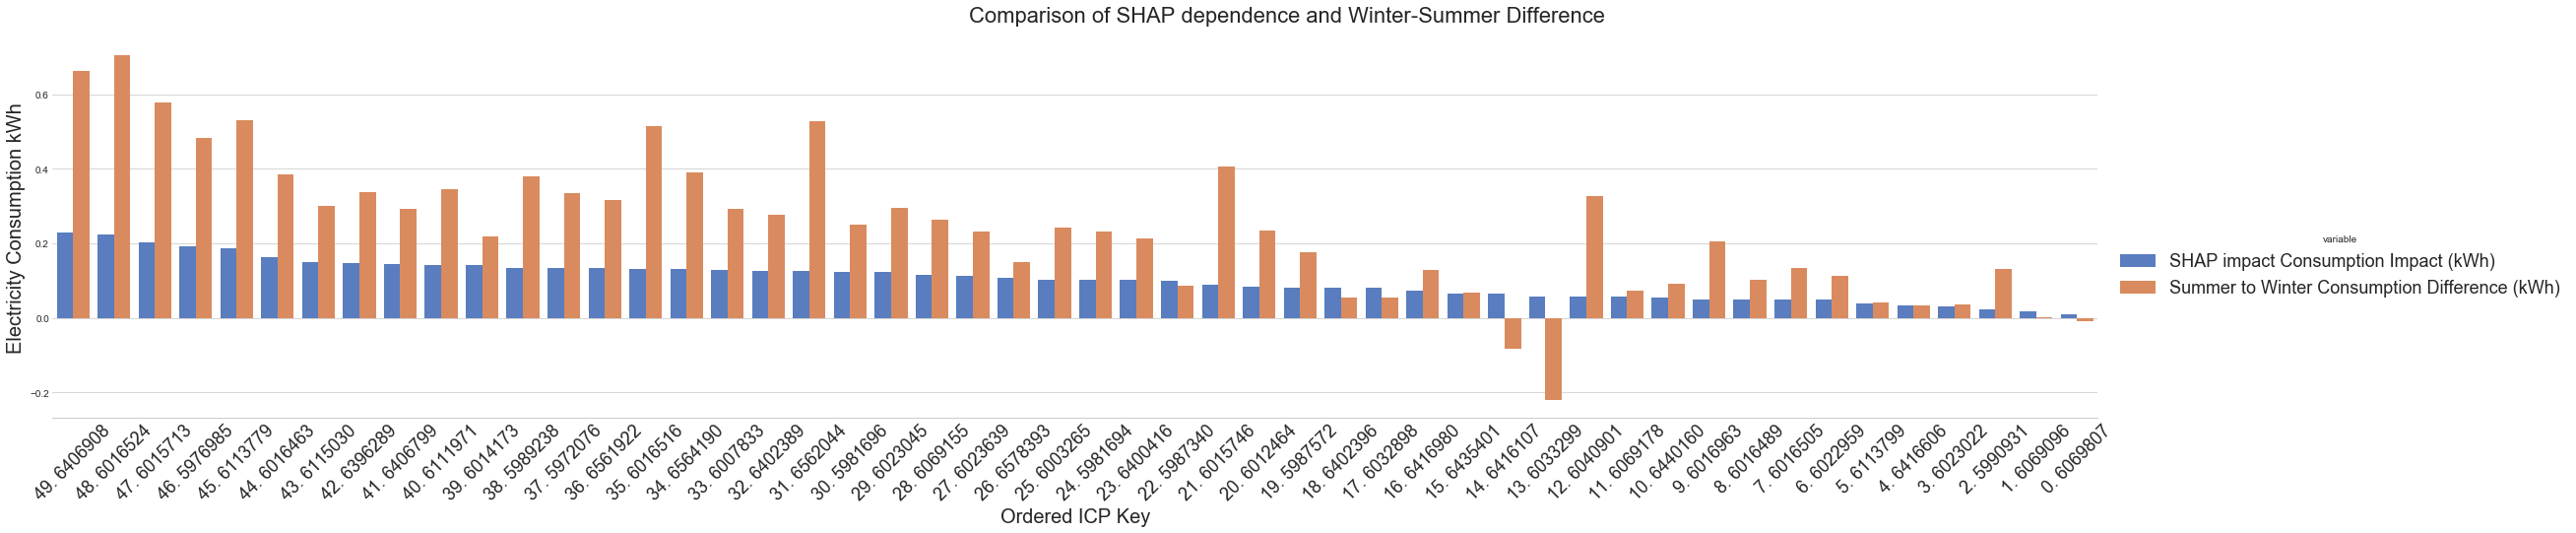

In [61]:
# Creating and saving a comparison figure
plt.figure(figsize=(20,20))
with sns.plotting_context(rc={"legend.fontsize":18}):
    ax = sns.catplot(x="Ordered ICP Key", y="value", hue="variable", data=temp_dep_df,
                height=6, aspect=5, kind="bar", palette="muted")
    # sns.barplot(x=temp_dep_df.index, y="value", data=temp_dep_df)
    ax.despine(left=True)
    ax.fig.suptitle('Comparison of SHAP dependence and Winter-Summer Difference', fontsize=22, y=1.05)
    ax.set_xticklabels(rotation=45, size=18)
    ax.set_xticklabels(rotation=45, size=18)
    ax.axes[0,0].set_xlabel("Ordered ICP Key", fontsize=20)
    ax.axes[0,0].set_ylabel("Electricity Consumption kWh", fontsize=20)
    ax.savefig('figures/Comparison of SHAP dependence and Winter-Summer Diffrence.png', dpi=100)